# Crowdstrike Heroes | Machine Learning Track Challenge

## SQL Injection Attacks Detection

In [1]:
import sys
!{sys.executable} -m pip install sklearn tensorflow tensorflow_text tensorflow_decision_forests


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ------------------------------------ 455.9/455.9 MB 995.8 kB/s eta 0:00:00
     ---------------------------------------- 5.0/5.0 MB 22.8 MB/s eta 0:00:00


ERROR: Could not find a version that satisfies the requirement tensorflow_decision_forests (from versions: none)
ERROR: No matching distribution found for tensorflow_decision_forests
You should consider upgrading via the 'c:\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import numpy as np

import requests
import tensorflow as tf
import tensorflow_decision_forests as tfdf

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import numpy as np

import requests
import tensorflow as tf
import tensorflow_decision_forests as tfdf

ModuleNotFoundError: No module named 'pandas'

In [3]:
train_df = pd.read_csv('./sql_train.csv')
valid_df = pd.read_csv('./sql_val.csv')
test_df = pd.read_csv('./sql_test.csv')

train_df['Sentence'] = train_df['Sentence'].apply(lambda x: str(x))
valid_df['Sentence'] = valid_df['Sentence'].apply(lambda x: str(x))
test_df['Sentence'] = test_df['Sentence'].apply(lambda x: str(x))

In [16]:
## Unique Characters
# Get a set of chars for Sentence in each set of data
char_set_train = train_df['Sentence'].apply(set)
char_set_val = valid_df['Sentence'].apply(set)
char_set_test = test_df['Sentence'].apply(set)

# Perform the union of all these sets to obtain the unique characters in each set
unique_chars_train = reduce(set.union, char_set_train)
unique_chars_val = reduce(set.union, char_set_val)
unique_chars_test = reduce(set.union, char_set_test)

# Getting the unique characters across the entire dataset that was provided
sets_list = [unique_chars_train, unique_chars_val, unique_chars_test]
unique_chars_overall = set().union(*sets_list)

# Sort them by their corresponding ascii value
unique_chars_train = sorted(unique_chars_train, key=ord)
unique_chars_val = sorted(unique_chars_val, key=ord)
unique_chars_test = sorted(unique_chars_test, key=ord)

unique_chars_overall = sorted(unique_chars_overall, key=ord)

# Printing the results
print(f"There are {len(unique_chars_train)} unique chars in training set.")
print(unique_chars_train)

print(f"There are {len(unique_chars_val)} unique chars in validation set.")
print(unique_chars_val)

print(f"There are {len(unique_chars_test)} unique chars in testing set.")
print(unique_chars_test)

print(f"There are {len(unique_chars_overall)} unique chars across all datasets.")
print(unique_chars_overall)

There are 127 unique chars in training set.
['\x18', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '~', '\x80', '\x98', '\xa0', '£', '½', 'Ã', 'ß', 'â', 'ä', 'ö', 'ü', '—', '‘', '’', '“', '”', '거', '길', '나', '난', '다', '동', '리', '멋', '빠', '요', '있', '주', '추', '트', '하', '홍']
There are 111 unique chars in validation set.
[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 

# Observations regarding characters
- The full English alphabet, in both lowercase and uppercase
- All the digits from 0 to 9
- Whitespace: ' '
- Mathematical operators: 
- Korean Characters: 거, 길, 나, 난, 다, 동, 리, 멋, 빠, 요, 있, 주, 추, 트, 하, 홍
- Characters from other latin alphabets: Ã, ß, â, ä, ö, ü
- Non-ASCII characters present encoding errors in CSV: \x18, \x80, \x98, \xa0
- Logical and Mathematical Operators
- Punctuation Marks
- Special irrelevant symbols: ½
- Currencies
- etc.

# Regarding datasets
The out-of-vocabulary characters that may be encountered by the soon-to-be ML model should be handled somehow: either they should be removed in preprocessing, or the model should be built in such a way that its performance isn't affected by these characters.

# Regarding SQL Syntax
## Case-Sensitivity - Converting to lowercase
The provided dataset is comprised of **SQL injection snippets**. We know for a fact that **SQL syntax is, for the most part, case-insensitive**. Keywords such as (SELECT, CREATE_TABLE) can be written in any way and still run fine. When it comes to table names, case-sensitivity **can** be enabled in certain DBMS's, but **I don't believe this will negatively impact the performance of the model**.

For the purposes of this challenge, and if my assumptions are correct, **converting the dataset to lowercase will not cause any significant context loss**.

# Using existing research

To compensate for my lack of experience (and truth be told, knowledge...) I've decided to look up research papers on this matter in order to gain some insights on the problem. I believe this doesn't break any of the rules of ths\ competition, as I'm only using these sources to better decide on how to approach the problem and come up with a decent-ish solution.

Disclaimer: The information that was extracted from the papers wasn't subjected to rigurous analysis due to lack of time and lack of experience in the field. I'm superficially scanning the sources and naively using the conclusions and results in my solution.

The papers which I've considered for the current problem are:
- https://scholarworks.sjsu.edu/cgi/viewcontent.cgi?article=1649&context=etd_projects
- https://revistageintec.net/wp-content/uploads/2022/02/1939.pdf

Relevant information that I've extracted from these papers:
- CNN's (Neural Networks in general) are more accurate, but they are costly in terms of resources and time
- Decision Tree algorithms (Ex: Random Forest) perform similarly to CNN's, but at a fraction of the resource costs
=> Conclusion: The Accuracy-Cost ratio of RF is better in comparison to CNN, and it also requires a significantly lower training and testing time than a Convolutional Neural Network. Therefore, I'm going to implement a decision forest model.

- The data needs to be processed appropriately: remove excess whitespaces, unknown characters and so on

Going further, a decision forest model is quite robust to overfitting. The validation data can still be used for tuning the model.

In [21]:
# Preprocessing the data

# Removing extra spaces
train_df.Sentence = train_df.Sentence.replace(r'\s+', ' ', regex=True)
valid_df.Sentence = valid_df.Sentence.replace(r'\s+', ' ', regex=True)
test_df.Sentence = test_df.Sentence.replace(r'\s+', ' ', regex=True)

# Removing unused characters
desired_alphabet = [' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '~', '—', '‘', '’', '“', '”']

####### I ran out of time, skipping this to build the model








5241


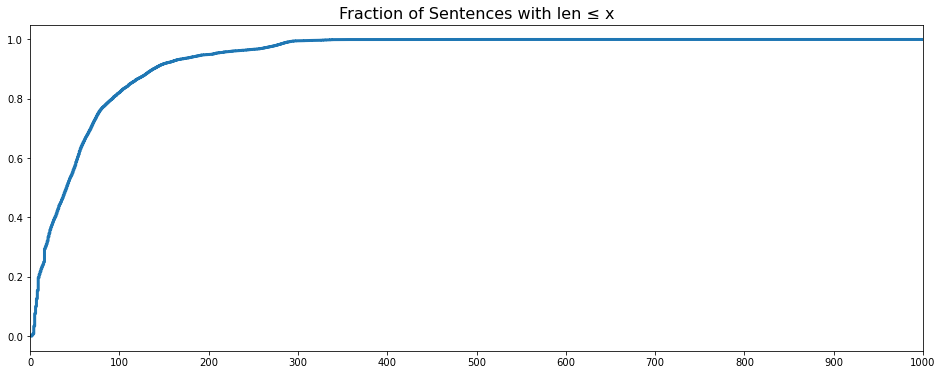

In [25]:
plt.figure(figsize=(16, 6))

x = np.sort(train_df['Sentence'].apply(len))
y = np.linspace(0, 1, len(x), endpoint=False)
plt.plot(x, y, lw=3)
plt.xticks(np.arange(0, x.max(), 100))
plt.xlim([0, 1000])

plt.title('Fraction of Sentences with len ≤ x', fontsize=16)
pass

print(max(train_df['Sentence'].apply(len)))




In [42]:
X_train = train_df['Sentence']
y_train = train_df['Label']

X_valid = valid_df['Sentence']
y_valid = valid_df['Label']

X_test = test_df['Sentence']

0                                                   49830
1                        1" ) ) ) union all select null--
2       1 ) union all select null,null,null,null,null,...
3       1' ) as bagi where 1281 = 1281 ( select ( case...
4       INSERT INTO mass ( gain, written, lunch, allow...
                              ...                        
5656     But Mr Hare rejected suggestion YMCA cultural...
5657                               1%' ) or sleep ( 5 ) #
5658                                            32425777d
5659                                    valido casademont
5660              nuestra seora del perpetuo socorro, 125
Name: Sentence, Length: 5661, dtype: object

In [57]:
# Tokenization

my_tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=None,
    filters='',
    lower=True,
    split=' ',
    char_level=True,
    oov_token=None
)

train_tokens = my_tokenizer.fit_on_texts(X_train)
valid_tokens = my_tokenizer.fit_on_texts(X_valid)
test_tokens = my_tokenizer.fit_on_texts(X_test)



In [61]:
# Building Model

model = tfdf.keras.RandomForestModel()
model.fit(train_df)

# Summary of the model structure.
model.summary()

# Evaluate the model.
model.evaluate(test_df)

# Export the model to a SavedModel.
model.save("project/model")




NameError: name 'tfdf' is not defined

In [ ]:
# Training






In [ ]:
# Tuning using validation set






In [ ]:
# Testing and getting predictions

In [3]:
# Assessing performance



I hope my shot at solving this problem is somewhat decent. Hoping for the best.
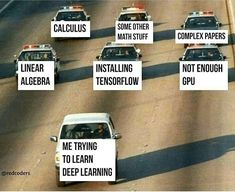